In [30]:
import numpy as np
a = np.array
import pandas as pd
from useful import auto199
from matplotlib import pyplot as plt

# 1.0 Load data

In [31]:
import pickle
with open('dataCache/pa.pkl','rb') as f:
    pa = pickle.load(f)
    # 1st index: phase or amplitude
    # 2nd index: temperature
    # 3rd index: k123
with open('dataCache/hddf.pkl','rb') as f:
    df = pickle.load(f)
with open('C02_arrcln.pkl', 'rb') as f:
    arr_cln, pk_choose = pickle.load(f)
with open('C02_angle.pkl', 'rb') as f:
    angle_restores = pickle.load(f)    

new_dt = {'fns':'110K_highres',
    'arr_clns':arr_cln,
    'colors':'#1f77b4',
    'nms':'110K(2)',
    'Ts':110,
    'nano':40,
    'sz':1024,
    'pxl20nm':512,
    'k123':pk_choose}
df = pd.concat([df, pd.DataFrame([new_dt])], ignore_index=True)

pa[0].append(angle_restores)

In [32]:
df

fns                                           arr_clns  \
0   2HTaSe2_bad_78K097  [[1.0103092144283519e-13, -3.5913526062327836e...   
1   2HTaSe2_ap_118K002  [[-1.5468118784470648e-12, 1.358354867116372e-...   
2  2HTaSe2_bae_110K012  [[-1.399080145167011e-12, -2.5197514098938278e...   
3   2HTaSe2_ao_115K037  [[5.857832103672808e-13, 2.382601548993847e-12...   
4                 test  [[4.992021943206503e-12, 3.452972262860198e-12...   
5         110K_highres  [[2.5767310122245523e-13, 4.0635659008804856e-...   

    colors      nms   Ts  nano    sz  pxl20nm         cntrs  resol  isb  \
0  #9467bd   78K(1)   78   160  2048      256  [1024, 1024]    1.0  0.0   
1  #1f77b4     118K  118    40   512      256    [256, 256]    1.0  4.0   
2  #ff7f0e     110K  110    80  1024      256    [512, 512]    1.0  2.0   
3  #289E28     115K  115    40  1024      512    [512, 512]    2.0  3.0   
4  #d62728   78K(2)   78    80  2048      512  [1024, 1024]    2.0  1.0   
5  #1f77b4  110K(2)  110    40  1024      512           NaN    NaN  NaN   

                                                k123  
0  [[114.0, 523.0], [-530.0, -177.0], [426.0, -34...  
1   [[18.0, 142.0], [-145.0, -48.0], [126.0, -94.0]]  
2  [[47.0, 281.0], [-296.0, -95.0], [251.0, -185.0]]  
3   [[31.0, 142.0], [-149.0, -48.0], [118.0, -94.0]]  
4  [[52.0, 258.0], [-277.0, -87.0], [225.0, -170.0]]  
5   [[26.0, 138.0], [-142.0, -47.0], [116.0, -91.0]]

# 2.0 Crop Window Surveyer

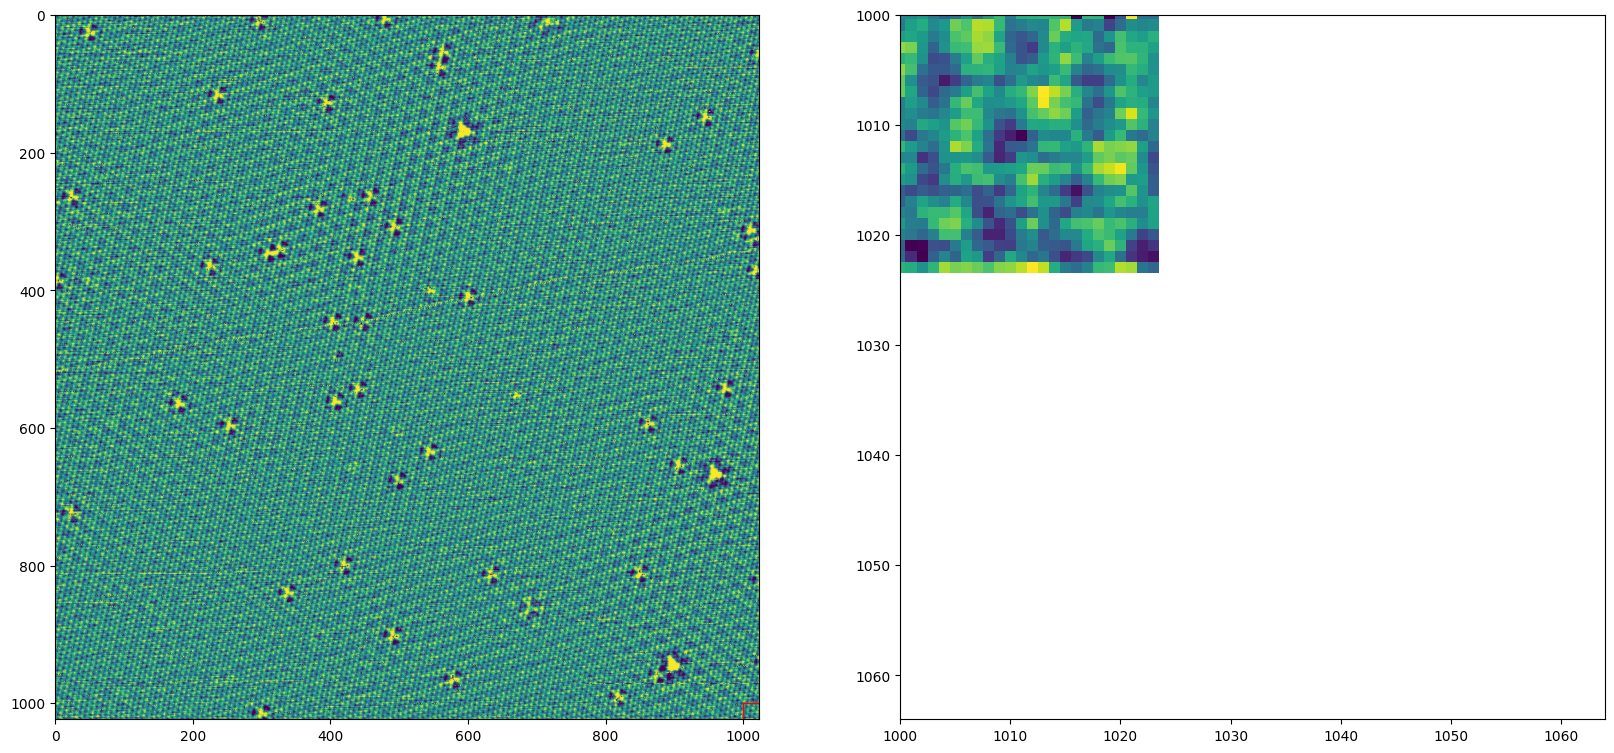

In [110]:


idx = 3
topo = df['arr_clns'][idx]
fig, axs = plt.subplots(1,2, figsize=(20,10))
xlim = np.array([0,64])+1000
ylim = np.array([64,0])+1000
axs[0].imshow(topo)
import matplotlib.patches as patches
rect = patches.Rectangle((xlim[0], ylim[0]), xlim[1]-xlim[0], ylim[1]-ylim[0], linewidth=1, edgecolor='r', facecolor='none')
axs[0].add_patch(rect)

plt.sca(axs[0])
auto199()
plt.sca(axs[1])
axs[1].imshow(topo)
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
auto199()
plt.show()

# 3.0 get FFT statitics

In [ ]:
import imagingPhase.ffts as imfft
def get_fft_prfl(arr_cln,k123):
    scl = 1.2
    atomPos = 1000      
    len_interp = int(atomPos*scl)+1#1201
    fft2abs = imfft.get_magnitude_spectrum(arr_cln)
    fft_pfls = []
    sz = arr_cln.shape
    p1 = np.array([sz[0]//2,sz[1]//2])
    for of3 in range(3):              
        p2 = k123[of3]*scl + p1
        fft_pfl = imfft.get_line_profile(fft2abs, p1, p2, len_interp)        
        fft_pfls.append(fft_pfl)
    return fft_pfls

def get_amp_shift(fft_pfl):
    amp_atom = fft_pfl[1000]
    start, end = 300, 360
    peak_index_relative = np.argmax(fft_pfl[start:end])
    peak_index_global = start + peak_index_relative
    amp_cdw = fft_pfl[peak_index_global]
    amp = amp_cdw/amp_atom
    shift = peak_index_global/1000
    return amp,shift    

check function works

In [37]:
idx = 4
arr_cln = df['arr_clns'][idx]
k123 = df['k123'][idx]
fft_pfls = get_fft_prfl(arr_cln,k123)
# plt.imshow(arr_cln)
for ik in range(3):
    plt.plot(fft_pfls[ik])
list(map(get_amp_shift,fft_pfls))    

[(np.float64(4.900296066497767), np.float64(-0.0033333333333332993)),
 (np.float64(3.6025807782002532), np.float64(-0.0013333333333332975)),
 (np.float64(3.3667521876841526), np.float64(-0.0003333333333332966))]

Apply to multiple datas

In [38]:
idx_ordered= [0,4,2,5,3,1]
df['nms'][idx_ordered]

0     78K(1)
4     78K(2)
2       110K
5    110K(2)
3       115K
1       118K
Name: nms, dtype: object

In [39]:
idx = 4
fft_pflss = []
amp_shifts = []
for idx in range(6):
    arr_cln = df['arr_clns'][idx]
    k123 = df['k123'][idx]
    fft_pfls = get_fft_prfl(arr_cln,k123)
    amp_shift = list(map(get_amp_shift,fft_pfls))
    fft_pflss.append(fft_pfls)
    amp_shifts.append(amp_shift)    

In [40]:
amp_shifts = np.array(amp_shifts)
amp_shifts.shape

(6, 3, 2)

In [41]:
df

fns                                           arr_clns  \
0   2HTaSe2_bad_78K097  [[1.0103092144283519e-13, -3.5913526062327836e...   
1   2HTaSe2_ap_118K002  [[-1.5468118784470648e-12, 1.358354867116372e-...   
2  2HTaSe2_bae_110K012  [[-1.399080145167011e-12, -2.5197514098938278e...   
3   2HTaSe2_ao_115K037  [[5.857832103672808e-13, 2.382601548993847e-12...   
4                 test  [[4.992021943206503e-12, 3.452972262860198e-12...   
5         110K_highres  [[2.5767310122245523e-13, 4.0635659008804856e-...   

    colors      nms   Ts  nano    sz  pxl20nm         cntrs  resol  isb  \
0  #9467bd   78K(1)   78   160  2048      256  [1024, 1024]    1.0  0.0   
1  #1f77b4     118K  118    40   512      256    [256, 256]    1.0  4.0   
2  #ff7f0e     110K  110    80  1024      256    [512, 512]    1.0  2.0   
3  #289E28     115K  115    40  1024      512    [512, 512]    2.0  3.0   
4  #d62728   78K(2)   78    80  2048      512  [1024, 1024]    2.0  1.0   
5  #1f77b4  110K(2)  110    40  1024      512           NaN    NaN  NaN   

                                                k123  
0  [[114.0, 523.0], [-530.0, -177.0], [426.0, -34...  
1   [[18.0, 142.0], [-145.0, -48.0], [126.0, -94.0]]  
2  [[47.0, 281.0], [-296.0, -95.0], [251.0, -185.0]]  
3   [[31.0, 142.0], [-149.0, -48.0], [118.0, -94.0]]  
4  [[52.0, 258.0], [-277.0, -87.0], [225.0, -170.0]]  
5   [[26.0, 138.0], [-142.0, -47.0], [116.0, -91.0]]

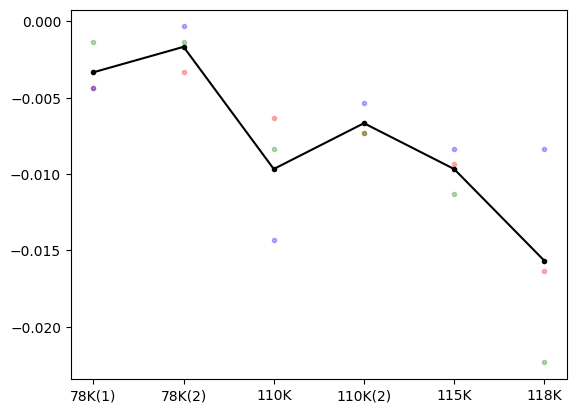

In [191]:
amp_shifts_mean = amp_shifts.mean(axis=1)
df['nms'][idx_ordered]
x = df['nms'][idx_ordered]
cs =['r','g','b']
for  ias in range(2):
    for ik in range(3):
        plt.plot(x,amp_shifts[idx_ordered,ik,ias],'.',alpha=.3,c=cs[ik])
    plt.plot(x,amp_shifts_mean[idx_ordered,ias],'k.-')
    if ias == 0:
        plt.ylim(0,1)
    plt.show()


In [62]:
idx_ordered

[0, 4, 2, 5, 3, 1]

In [ ]:

idx_final

[0, 5, 3, 1]

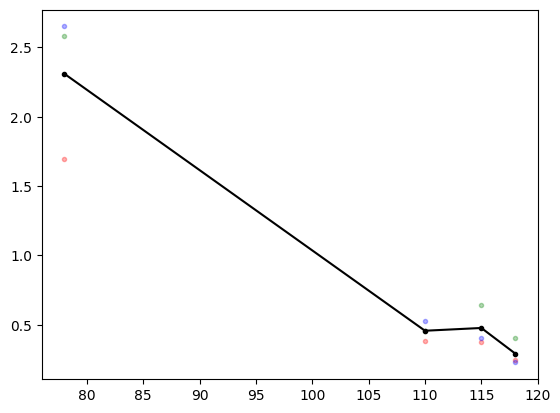

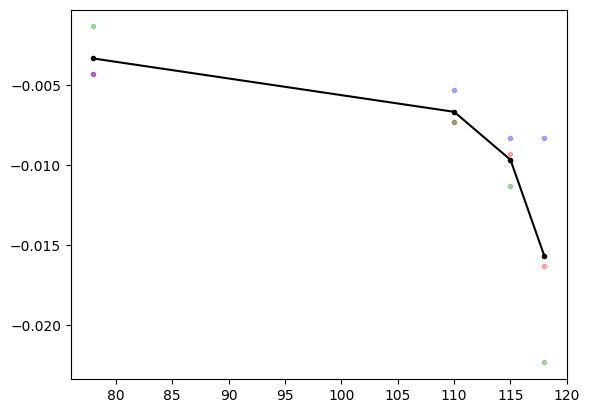

In [192]:
idx_final = [idx_ordered[i] for i in [0, 3, 4, 5]]
amp_shifts_mean = amp_shifts.mean(axis=1)
df['nms'][idx_final]
x = df['nms'][idx_final]
x = np.array([78,110,115,118])
cs =['r','g','b']
for  ias in range(2):
    for ik in range(3):
        plt.plot(x,amp_shifts[idx_final,ik,ias],'.',alpha=.3,c=cs[ik])
    plt.plot(x,amp_shifts_mean[idx_final,ias],'k.-')
    # if ias == 0:
    #     plt.ylim(0,1)
    plt.show()

# 4.0 phasemap statitics

load functions

In [76]:
from useful import color_histogram
import imagingPhase.get_phimap as gpm
ua = np.array([-1, 1])*np.pi
dfphase = pd.DataFrame({
'arrfcn':[lambda x:x,gpm.wrap_phase,lambda x: gpm.wrap_phase(3*x)/3],
'cmap':['jet','twilight_shifted','RdBu'],
'clim':[ua*3,ua*(1),ua*(1/3)],
'phaseStr':['monotonic','circular','circular(x3)'],
'ticks':[[-np.pi*3, -np.pi*(2/3), 0, np.pi*(2/3), np.pi*3],
    [-np.pi, -np.pi*(2/3), 0, np.pi*(2/3), np.pi],
    [ -np.pi*(1/3), 0, np.pi*(1/3)]],
'tick_labels':[[r"$-3\pi$", r"$-\frac{2}{3}\pi$" ,"", r"$\frac{2}{3}\pi$" ,r"$3\pi$"],
[r"$-\pi$", r"$-\frac{2}{3}\pi$" ,r"$0$", r"$\frac{2}{3}\pi$" ,r"$\pi$"],
[r"$-\frac{1}{3}\pi$" ,r"$0$", r"$\frac{1}{3}\pi$" ]]
})

In [44]:
sig = 10
idx = 1
arr_cln = df['arr_clns'][idx]
pk_choose = df['k123'][idx]
print(pk_choose)
# angle_restores = gpm.phi2Hrecover(arr_cln, pk_choose, sig)

[[  18.  142.]
 [-145.  -48.]
 [ 126.  -94.]]


single

In [84]:
# fig,axs = plt.subplots(1,3,figsize=(15,5))
idt = 2
iwrap = 1

dfphaseNow = dfphase.iloc[iwrap]

dt = pa[0][0][ik]
dt_wrap = dfphaseNow['arrfcn'](dt)
plt.imshow(dt_wrap,cmap=dfphaseNow['cmap'],clim=dfphaseNow['clim'])    



In [85]:
color_histogram(dt_wrap.flatten(),clim=dfphaseNow['clim'],cmap=dfphaseNow['cmap'])

get phase map for figure

0
5
3
1


d:\github\2H_TaSe2_Tc_STM\2Hvenv\Lib\site-packages\numpy\lib\_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


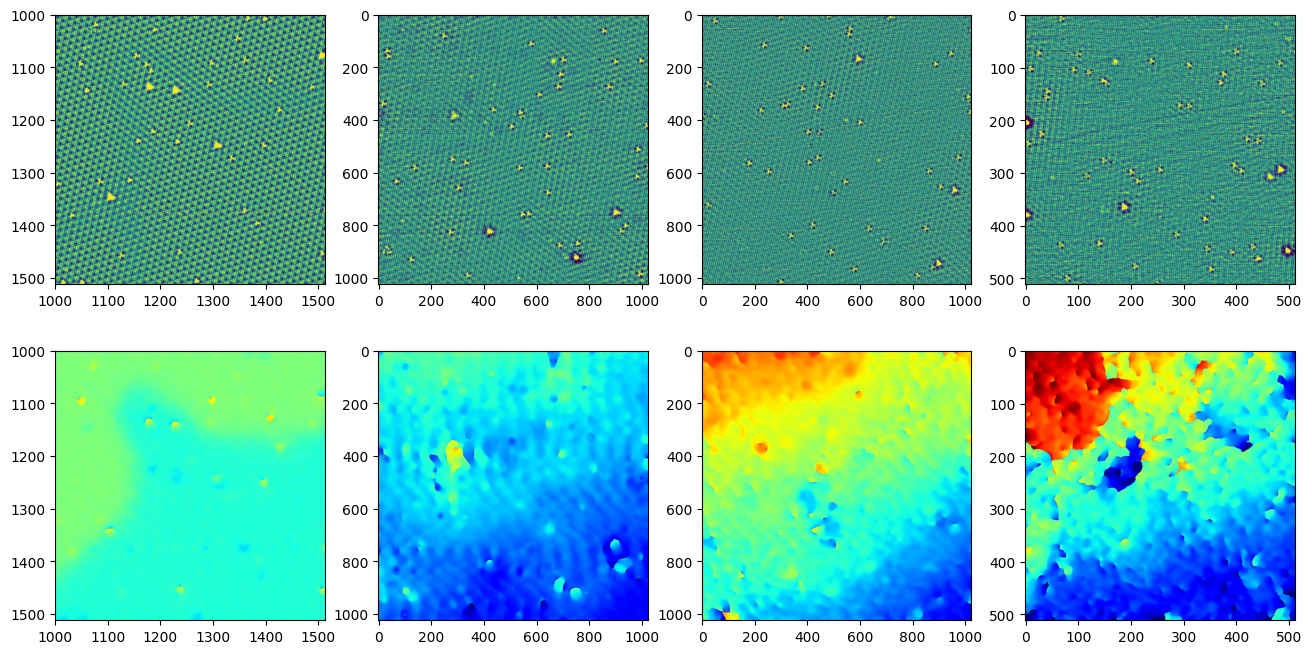

In [135]:
fig,axs = plt.subplots(2,4,figsize=(16,8))
ik = 1
dfphaseNow = dfphase.iloc[0]
for jsb in range(4):
    idx = idx_final[jsb]
    print(idx)    
    dt = pa[0][idx][ik]
    dt_wrap = dfphaseNow['arrfcn'](dt)
    topo = df['arr_clns'][idx]
    # if jsb ==0:
    #     dt_wrap = dt_wrap[]
    #     topo = topo
    axs[0,jsb].imshow(topo)
    
    plt.sca(axs[0,jsb])
    auto199()

    axs[1,jsb].imshow(dt_wrap,cmap=dfphaseNow['cmap'],clim=dfphaseNow['clim'])    
xlim = np.array([0,512])+1000
ylim = np.array([512,0])+1000
jsb = 0
axs[0,jsb].set_xlim(xlim)
axs[0,jsb].set_ylim(ylim)
axs[1,jsb].set_xlim(xlim)
axs[1,jsb].set_ylim(ylim)
fig.savefig('phimap_temperature.svg', bbox_inches='tight')


In [133]:
dfphaseNow = dfphase.iloc[2]

jsb = 1
idx = idx_final[jsb]
print(idx)    
dt = pa[0][idx][ik]
dt_wrap = dfphaseNow['arrfcn'](dt)
tht = dt_wrap*3
tht = tht.flatten()


5


In [160]:
def cicular_mean(phi):
    phi = phi.flatten()
    C = np.cos(tht).sum()
    S = np.sin(tht).sum()
    R  =np.sqrt(C**2+S**2)/len(tht)    
    THT = np.arctan2(S,C)
    return R,THT

In [134]:
C = np.cos(tht).sum()
S = np.sin(tht).sum()
R  =np.sqrt(C**2+S**2)/len(tht)
print(R)

0.09912424651516903


In [161]:
R,THT = cicular_mean(tht)

In [163]:
THT

np.float64(-2.72929449221397)

In [ ]:


ik = 0
jsb = 0
idx = idx_final[jsb]

print(df['fns'][idx])    
dt = pa[0][idx][ik]
x_grad,y_grad = np.gradient(dt)
x_grad,y_grad = np.gradient(dt)
v = [x_grad.mean(),y_grad.mean()]
print(v)

2HTaSe2_bad_78K097
[np.float64(-0.0020202145751238025), np.float64(-0.0004836053331131891)]


# 5.0 Guage fixing of 110K

In [ ]:
def gauge_fixer(phi_fields,phi1,phi2):
    phi3 = -phi1-phi2
    phis = [phi1,phi2,phi3]
    phi_fields_new = phi_fields
    phi_fields_new[:,:,0] = phi_fields_new[:,:,0] + phi1 
    phi_fields_new[:,:,1] = phi_fields_new[:,:,1] + phi2
    phi_fields_new[:,:,2] = phi_fields_new[:,:,2] + phi3
    return phi_fields_new

In [190]:
phi1 = -2.8
phi2 = 1.5
phi3 = 3
phis = [phi1,phi2,phi3]
ivis = 0
fig,axs = plt.subplots(2,3)
for isb in range(2):
    iwrap = isb+ 1
    dfphaseNow = dfphase.iloc[iwrap]
    for jsb in range(3):
        plt.sca(axs[isb][jsb])
        ik = jsb
        dt = pa[0][5][ik] - phis[ik]
        dt_wrap = dfphaseNow['arrfcn'](dt)
        if ivis == 0:
            plt.imshow(dt_wrap,cmap=dfphaseNow['cmap'],clim=dfphaseNow['clim'])                
            plt.xticks([])
            plt.yticks([])
        if ivis == 1:
            color_histogram(dt_wrap.flatten(),clim=dfphaseNow['clim'],cmap=dfphaseNow['cmap'])
        


In [ ]:
idt = 2


iwrap = 2
dfphaseNow = dfphase.iloc[iwrap]
dt = pa[0][5][ik]
dt_wrap = dfphaseNow['arrfcn'](dt)
plt.imshow(dt_wrap,cmap=dfphaseNow['cmap'],clim=dfphaseNow['clim'])